# Rewriting Game of Thrones Vectors by Siraj Raval

Siraj Raval made a YouTube video in which he creates word vectors from A Song Of Ice And Fire books. In that video he uses a bunch of smaller librarys, but I wanted to rewrite it in Tensorflow, because Tensorflow is the greatest library that ever was, or ever will be.

In [1]:
import re
import tensorflow as tf
import glob
import collections
import math
import os
import numpy as np
import random
from matplotlib import pyplot
from sklearn.manifold import TSNE

%matplotlib inline
pyplot.rcParams['figure.figsize'] = (15, 15)

Read the .txt files.

### Section 1: Read the data

In [2]:
def format_data():
    data = []
    for file in glob.glob("data/*.txt"):
        with open(file) as f:
            str = tf.compat.as_str(f.read())
            pattern = re.compile('[^a-zA-Z]')
            str = re.split(pattern, str)
            str.remove('')
            str = [i.lower() for i in str]
            data += str
    return data


words = format_data()
print(len(words))

2274195


Now we need to create data we can use. We need a dictionary, whose keys are numbers and values are strings) and a reverse dictionary(keys are strings and values are numbers).

In [3]:
vocabulary_size = 22000


def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary


data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK): {}'.format(count[:5]))
print('Sample data: {}'.format(data[:10]))
print('Reversed dictionary size: {}'.format(len(reverse_dictionary)))

Most common words (+UNK): [['UNK', 959], ('', 456092), ('the', 104699), ('and', 52857), ('a', 40715)]
Sample data: [58, 4838, 1309, 1309, 1, 4163, 1, 4, 635, 6]
Reversed dictionary size: 22000


In the function below, we create valid batches for training. Skip window tells us how many words, on each side of the input words, do we want to look at for training.

In [4]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert  num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size//num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in     targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

And a quick test.

In [5]:
print('data', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print("\nwith num_skips = {} and skip_window = {}".format(num_skips, skip_window))
    print("     batch: {}".format([reverse_dictionary[bi] for bi in batch]))
    print("     labels: {}".format([reverse_dictionary[li] for li in labels.reshape(8)]))

data ['by', 'george', 'r', 'r', '', 'martin', '', 'a']

with num_skips = 2 and skip_window = 1
     batch: ['george', 'george', 'r', 'r', 'r', 'r', '', '']
     labels: ['r', 'by', 'r', 'george', '', 'r', 'martin', 'r']

with num_skips = 4 and skip_window = 2
     batch: ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']
     labels: ['george', 'r', '', 'by', 'martin', '', 'george', 'r']


### Section 2: Training

In [6]:
batch_size = 128
# Dimensionality of the vectors. More dimensions, more accurate the predictions, 
# but more computationally expensive also.
embedding_size = 128
skip_window = 1
num_skips = 2
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()

with graph.as_default():
    train_dataset = tf.placeholder(dtype=tf.int32, shape=(batch_size))
    train_labels = tf.placeholder(dtype=tf.int32, shape=(batch_size, 1))
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embed')
    weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                              stddev=1.0/(math.sqrt(embedding_size))), 
                          name='weights')
    biases = tf.Variable(tf.zeros([vocabulary_size]), name='biases')

    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=weights, biases=biases, inputs=embed,
                                   labels=train_labels, num_sampled=num_sampled, 
                                   num_classes=vocabulary_size)
    )

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Save the model,
    saver = tf.train.Saver()
    # Find the closest words.
    # Here we use cosine similarity.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized!')
    average_loss = 0
    for step in range(num_steps):
        # Create batch data and labels.
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        # Print average loss every 2000 steps.
        if step % 2000 == 0:
            if step > 0:
                print('Average loss at step {}: {}'.format(step, average_loss/2000))
                average_loss = 0
        # Print similar words every 10000 steps.
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                # Sort the words.
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = 'Nearest to {}: '.format(valid_word)
                for k in range(top_k):
                    nearest_k = nearest[k]
                    near_word = reverse_dictionary[nearest_k]
                    log = '{} {}, '.format(log, near_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()
    # Save the model is the directory model.
    saver.save(sess=session, save_path=os.path.join(os.getcwd(), '/tmp/model.ckpt'))

Initialized!
Nearest to into:  lurkers,  trademark,  announcement,  covetous,  retreat,  streamed,  crosses,  trafficked, 
Nearest to man:  ironwoods,  incoherent,  frosts,  ropy,  reverse,  beside,  fetter,  atoned, 
Nearest to never:  next,  damasks,  kromm,  snuffed,  horn,  threaded,  hovered,  darting, 
Nearest to you:  mutters,  ghazdor,  lighter,  duel,  skyward,  workers,  stern,  anyhow, 
Nearest to him:  robbing,  appalled,  turncloak,  refusals,  tossing,  hungrier,  fluent,  fern, 
Nearest to how:  yunkish,  planky,  plight,  genuine,  expansively,  cowhide,  snakepit,  zei, 
Nearest to thought:  outrider,  gelding,  sybell,  gore,  qohor,  sloughing,  uncommon,  disposing, 
Nearest to he:  matter,  vanquishing,  bumpy,  coins,  jordayne,  lunge,  rus,  commands, 
Nearest to not:  plunges,  unless,  harmond,  sylas,  feverish,  flingers,  veins,  prowess, 
Nearest to been:  gullet,  breathing,  spectators,  silently,  bitching,  shops,  prolong,  outdo, 
Nearest to or:  faw

Nearest to he:  she,  they,  i,  we,  it,  dany,  tyrion,  jaime, 
Nearest to not:  never,  you,  unquiet,  quite,  coils,  mooned,  only,  puzzles, 
Nearest to been:  be,  re,  was,  were,  are,  bullocks,  seen,  died, 
Nearest to or:  and,  inhaling,  honorific,  trench,  brushes,  relied,  haphazardly,  pleasantries, 
Nearest to only:  ordained,  just,  garrisons,  even,  auntie,  discomfiture,  guardsman,  swat, 
Nearest to down:  back,  up,  off,  out,  across,  over,  lightly,  through, 
Nearest to father:  mother,  husband,  browed,  bolton,  bedmaid,  brother,  grandfather,  cutpurses, 
Nearest to who:  utmost,  always,  he,  whose,  scare,  never,  ever,  what, 
Nearest to when:  before,  if,  till,  exasperated,  sometimes,  then,  ruefully,  dolorous, 
Average loss at step 52000: 2.962158954977989
Average loss at step 54000: 2.9676380719542506
Average loss at step 56000: 2.9611930784583094
Average loss at step 58000: 2.8632583005428316
Average loss at step 60000: 2.91926835

### Section 3: Plotting

Here, we shink the embeddings from 128 dimensions to just 2. We do this through a method called TSNE

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
twoD_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

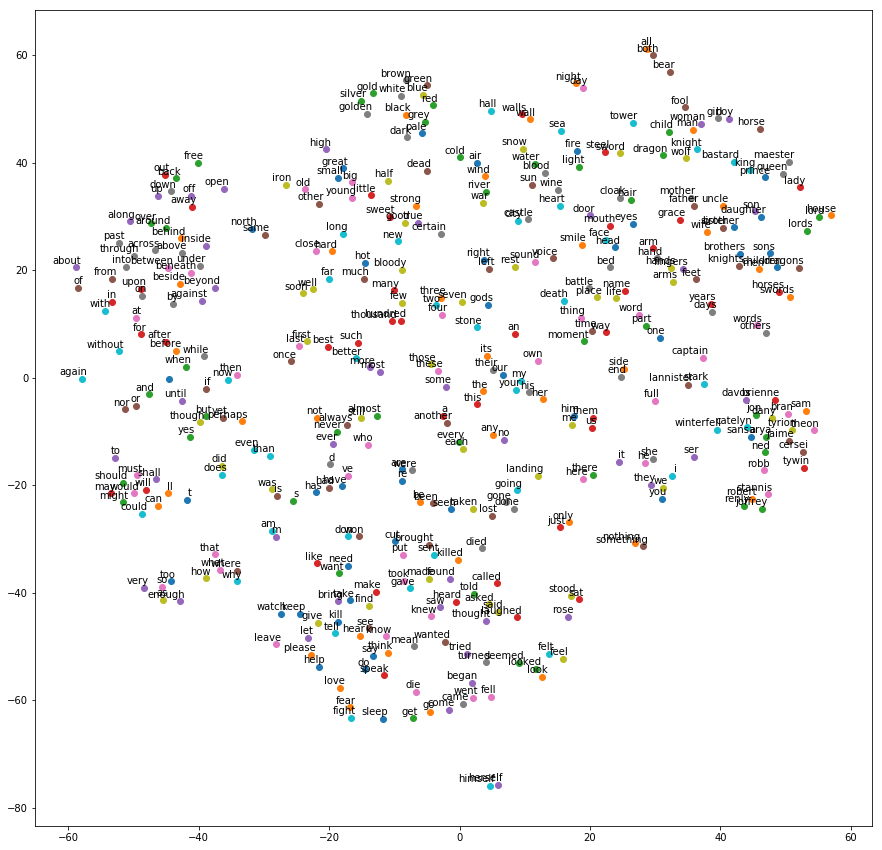

In [9]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings!'
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pyplot.scatter(x, y)
        pyplot.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(twoD_embeddings, words)
pyplot.show()